In [1]:
!pip3 install fastFM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastFM: filename=fastFM-0.2.10-cp310-cp310-linux_x86_64.whl size=591780 sha256=15ad9c97cadcbd4d40cf65c67fcabbc7d89db2859163749701291018d436e501
  Stored in directory: /root/.cache/pip/wheels/93/92/52/2da7997fcb7a7ce9042ff3b33836ef0c2fd47aa95382d7a113
Successfully built fastFM


In [34]:
!pip install psutil

In [35]:
import os
import numpy as np
import pandas as pd
import fastFM
from fastFM.datasets import make_user_item_regression
from fastFM import sgd
from fastFM import als
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from fastFM import mcmc
import functools as fct
import itertools as itools
import random, scipy
import psutil
import time

In [3]:
train_df = pd.read_csv("training_set.csv")
train_df.head()

,userID,itemID,styleID,rating
0,401,32780,12224,3.0
1,7548,21688,9020,3.5
2,7663,1521,568,4.0
3,1357,3824,1417,3.5
4,1361,727,263,4.5


In [4]:
validation_df = pd.read_csv("validation_set.csv")
validation_df.head()

user_items_test = {}

for row in validation_df.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[2])

In [5]:
items_styles = pd.read_csv("items_styles.csv")
items_styles.head()

,itemID,styleID
0,11757,1199
1,5441,1199
2,19960,1199
3,55900,1199
4,57110,14879


## Definición de métricas

In [6]:
# Definicion de métricas (No editar)
# Inspirado parcialmente en https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def recall_at_k(r, k, m):
    return (np.asarray(r)[:k] != 0).sum() / m

def average_precision_at_k(r, k, m):
    r = np.asarray(r)
    sum_precision = 0
    for i in range(min(k, r.size)):
        if r[i] != 0:
            sum_precision += precision_at_k(r, i + 1)
    return sum_precision / min(m, k)

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [7]:
item_counts = train_df["itemID"].value_counts()
total_interactions = len(train_df)
items_popularity = item_counts / total_interactions
items_popularity = items_popularity.to_dict()
mean_popularity = np.mean(list(items_popularity.values()))

def novelty_for_user(recommendations):
    popularities = np.array([items_popularity[i] if i in items_popularity.keys() else mean_popularity for i in recommendations])
    return np.sum(np.log(1 / popularities)) / len(recommendations)

In [8]:
item_categories = items_styles.set_index("itemID")["styleID"].to_dict()

def diversity_for_user(recommendations, categories=item_categories):
    recommended_categories = [categories[item] for item in recommendations]
    unique_categories = len(set(recommended_categories))

    return unique_categories / len(recommendations)


## Convertir a formato fastFM

In [9]:
def get_single_entries_in_fm_input_format(data, itemlist):

    '''Cree el formato de entrada necesario (datos, (fila, columna)) para la matriz csc para
    las entradas individuales en los datos. Cada entrada ocuparía una fila. Esto significa que
    daría como resultado una matriz csc con dimensión (| datos | x | lista de elementos |).
    '''

    column = len(itemlist)
    row = len(data)
    shape = (row, column)

    row_inds = np.zeros(len(data), dtype=np.int32)
    col_inds = np.zeros(len(data), dtype=np.int32)
    datalist = np.zeros(len(data), dtype=np.float32)

    for i in range(len(data)):
        item = data[i]
        val = 1
        datalist[i] = val

        # ubica su posición en la lista de elementos, arroja un error si el elemento no es un
        # artículo posible
        col_ind = np.where(itemlist==item)[0]

        # no deben ser elementos duplicados en la lista de elementos
        assert len(col_ind) == 1
        col_ind = col_ind[0]
        row_ind = i

        col_inds[i] = col_ind
        row_inds[i] = row_ind

    return datalist, row_inds, col_inds, shape


def get_multi_entries_in_fm_input_format(data, itemlist, norm_func=None):

    '''Cree el formato de entrada necesario (datos, (fila, columna)) para la matriz csc para
    las entradas múltiples en los datos. Cada conjunto de entradas múltiples ocuparía una fila.
    Esto significa que daría como resultado una matriz csc con dimensión
    (| conjuntos de entradas en datos | x | lista de elementos |).
    '''

    column = len(itemlist)

    # número de conjuntos de entradas en los datos
    row = len(data)
    shape = (row, column)

    # numero de datos
    num_of_data = fct.reduce(lambda x, y: x + len(y), data, 0)
    row_inds = np.zeros(num_of_data, dtype=np.int32)
    col_inds = np.zeros(num_of_data, dtype=np.int32)
    datalist = np.zeros(num_of_data, dtype=np.float32)
    cnt = 0
    for i in range(len(data)):
        multi_entry = data[i]

        if norm_func != None:
            # función que recibe el tamaño del multi_entry para decidir cómo normalizarlo
            val = norm_func(len(multi_entry))
        else:
            # asignación de valor binario por defecto
            val = 1 if len(multi_entry) > 0 else 0

        # para cada entrada en multi_entry, ubique su posición en la lista de elementos,
        # arroja error si el elemento no es un elemento posible
        # todas las entradas permanecen en la misma fila
        row_ind = i
        for item in multi_entry:
            col_ind = np.where(itemlist==item)[0]
            assert len(col_ind) == 1
            col_ind = col_ind[0]

            datalist[cnt] = val
            col_inds[cnt] = col_ind
            row_inds[cnt] = row_ind

            # actualiza contador
            cnt += 1

    return datalist, row_inds, col_inds, shape

### Conversión de los datos

In [10]:
beerlist = items_styles.sort_values('itemID')['itemID'].unique()
userlist = train_df.sort_values('userID')['userID'].unique()
stylelist = items_styles.sort_values('styleID')['styleID'].unique()


# usuarios que dieron ratings
user_data = train_df['userID'].values

# items que recibieron ratings
beer_data = train_df['itemID'].values

# data de estilo de cerveza
styles_data = train_df['styleID'].values

# target vector: ratings
rating_data = train_df['rating'].values


# convertir a formato fastFM utilizando funciones de arriba
user_datalist, user_row_inds, user_col_inds, user_shape = get_single_entries_in_fm_input_format(data=user_data,
                                                                                                itemlist=userlist)

beer_datalist, beer_row_inds, beer_col_inds, beer_shape = get_single_entries_in_fm_input_format(data=beer_data,
                                                                                                   itemlist=beerlist)

style_datalist, style_row_inds, style_col_inds, style_shape = get_single_entries_in_fm_input_format(data=styles_data,
                                                                                                   itemlist=stylelist)

# Concatena las dos columnas cambiando los índices de las columnas relacionadas con beer.
# cambiar por el número de columnas en las columnas de usuario
shift_by = len(userlist)
beer_col_inds += shift_by

# concatena los datos (agregamos item_styles)
datalist = np.append(user_datalist, [beer_datalist, style_datalist])
row_inds = np.append(user_row_inds, [beer_row_inds, style_row_inds])
col_inds = np.append(user_col_inds, [beer_col_inds,style_col_inds])

# asegúrese de que ambos conjuntos de características tengan el mismo número de filas
print('User feature set shape: {}\nItem feature set shape: {}\nStyle feature set shape: {}'.format(user_shape, beer_shape, style_shape))

assert user_shape[0] == beer_shape[0]
shape = (user_shape[0], user_shape[1] + beer_shape[1] + style_shape[1])
print('Dimension of FM input: {}'.format(shape))


X_train = csc_matrix((datalist, (row_inds, col_inds)), shape=shape)
y_train = rating_data

User feature set shape: (35534, 8320)
Item feature set shape: (35534, 1836)
Style feature set shape: (35534, 210)
Dimension of FM input: (35534, 10366)


In [11]:
# usuarios que dieron ratings
user_data = validation_df['userID'].values

# items que recibieron ratings
beer_data = validation_df['itemID'].values

# data de estilo de cerveza
styles_data = validation_df['styleID'].values

# target vector: ratings
rating_data = validation_df['rating'].values


# convertir a formato fastFM utilizando funciones de arriba
user_datalist, user_row_inds, user_col_inds, user_shape = get_single_entries_in_fm_input_format(data=user_data,
                                                                                                itemlist=userlist)

beer_datalist, beer_row_inds, beer_col_inds, beer_shape = get_single_entries_in_fm_input_format(data=beer_data,
                                                                                                   itemlist=beerlist)

style_datalist, style_row_inds, style_col_inds, style_shape = get_single_entries_in_fm_input_format(data=styles_data,
                                                                                                   itemlist=stylelist)

# Concatena las dos columnas cambiando los índices de las columnas relacionadas con beer.
# cambiar por el número de columnas en las columnas de usuario
shift_by = len(userlist)
beer_col_inds += shift_by

# concatena los datos (agregamos item_styles)
datalist = np.append(user_datalist, [beer_datalist, style_datalist])
row_inds = np.append(user_row_inds, [beer_row_inds, style_row_inds])
col_inds = np.append(user_col_inds, [beer_col_inds,style_col_inds])

# asegúrese de que ambos conjuntos de características tengan el mismo número de filas
print('User feature set shape: {}\nItem feature set shape: {}\nStyle feature set shape: {}'.format(user_shape, beer_shape, style_shape))

assert user_shape[0] == beer_shape[0]
shape = (user_shape[0], user_shape[1] + beer_shape[1] + style_shape[1])
print('Dimension of FM input: {}'.format(shape))

X_validation = csc_matrix((datalist, (row_inds, col_inds)), shape=shape)
y_validation = rating_data

User feature set shape: (8845, 8320)
Item feature set shape: (8845, 1836)
Style feature set shape: (8845, 210)
Dimension of FM input: (8845, 10366)


In [31]:
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=10, l2_reg_w=0.1, l2_reg_V=0.5)
fm.fit(X_train, y_train)

FMRegression(l2_reg_V=0.5, n_iter=1000, rank=10)

In [13]:
y_pred = fm.predict(X_validation)

In [14]:
from sklearn.metrics import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse = root_mean_squared_error(y_validation, y_pred)
print(f"RMSE: {rmse}")

RMSE: 0.8378507457519454


In [15]:
def parse_data_for_user(user_id):
  beer_data = items_styles["itemID"].values
  user_data = [user_id] * len(beer_data)
  styles_data = items_styles["styleID"].values

  # convertir a formato fastFM utilizando funciones de arriba
  user_datalist, user_row_inds, user_col_inds, user_shape = get_single_entries_in_fm_input_format(data=user_data,
                                                                                                  itemlist=userlist)

  beer_datalist, beer_row_inds, beer_col_inds, beer_shape = get_single_entries_in_fm_input_format(data=beer_data,
                                                                                                    itemlist=beerlist)

  style_datalist, style_row_inds, style_col_inds, style_shape = get_single_entries_in_fm_input_format(data=styles_data,
                                                                                                    itemlist=stylelist)

  # Concatena las dos columnas cambiando los índices de las columnas relacionadas con beer.
  # cambiar por el número de columnas en las columnas de usuario
  shift_by = len(userlist)
  beer_col_inds += shift_by

  # concatena los datos (agregamos item_styles)
  datalist = np.append(user_datalist, [beer_datalist, style_datalist])
  row_inds = np.append(user_row_inds, [beer_row_inds, style_row_inds])
  col_inds = np.append(user_col_inds, [beer_col_inds,style_col_inds])

  # asegúrese de que ambos conjuntos de características tengan el mismo número de filas

  assert user_shape[0] == beer_shape[0]
  shape = (user_shape[0], user_shape[1] + beer_shape[1] + style_shape[1])

  X_test = csc_matrix((datalist, (row_inds, col_inds)), shape=shape)
  return X_test

In [16]:
def get_top_n_recommendations(model, user_id, n=10):
    X_test = parse_data_for_user(user_id)
    y_test = model.predict(X_test)
    predictions = [(beer_data[i], y_test[i]) for i in range(len(y_test))]
    predictions.sort(key=lambda x: x[1], reverse=True)
    return [prediction[0] for prediction in predictions[:n]]

In [17]:
ranking = get_top_n_recommendations(fm, 1040)
print(ranking)

[17538, 48911, 21822, 436, 20470, 11757, 429, 60511, 21822, 1504]


## Análisis de sensibilidad

In [18]:
def evaluate_model(model, n):
  mean_ap = 0. # o MAP
  mean_ndcg = 0.
  mean_recall = 0.
  novelty = 0
  diversity = 0


  for u in user_items_test.keys():
    relevant_items = user_items_test[u]
    rec = get_top_n_recommendations(model, u, n)
    rel_vector = np.isin(relevant_items, rec, assume_unique=True).astype(int)

    mean_ap += average_precision_at_k(rel_vector, n, len(relevant_items))
    mean_ndcg += ndcg_at_k(rel_vector, n, len(relevant_items))
    mean_recall += recall_at_k(rel_vector, n, len(relevant_items))
    novelty += novelty_for_user(rec)
    diversity += diversity_for_user(rec)

  mean_ap /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  mean_recall /= len(user_items_test)
  novelty /= len(user_items_test)
  diversity /= len(user_items_test)

  return mean_ap, mean_ndcg, mean_recall, novelty, diversity

In [19]:
iterations_values = [500, 750, 1000]
lambda_values = [0.001, 0.01, 0.1]

map_values = []
ndcg_values = []

for iteration in iterations_values:
    map_row = []
    ndcg_row = []
    for lamb in lambda_values:
      fm = als.FMRegression(n_iter=iteration, init_stdev=0.1, rank=10, l2_reg_w=lamb, l2_reg_V=0.5)
      fm.fit(X_train, y_train)
      mean_ap, mean_ndcg, _, _, _ = evaluate_model(fm, 10)
      map_row.append(mean_ap)
      ndcg_row.append(mean_ndcg)

    map_values.append(map_row)
    ndcg_values.append(ndcg_row)

iter_values, lamb_values = np.meshgrid(iterations_values, lambda_values)

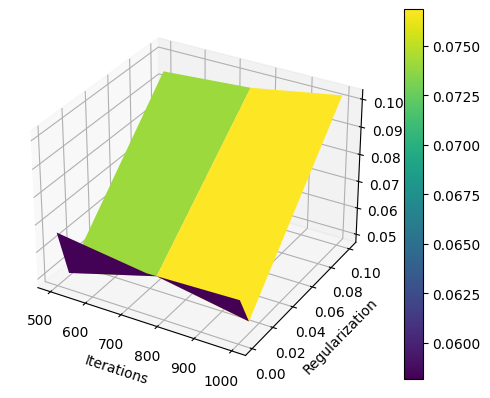

In [20]:
from matplotlib import cm

map_values = np.array(map_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(iter_values, lamb_values, map_values.T, cmap=cm.viridis)

ax.set_xlabel('Iterations')
ax.set_ylabel('Regularization')
ax.set_zlabel('MAP@10')

fig.colorbar(surf)
plt.show()

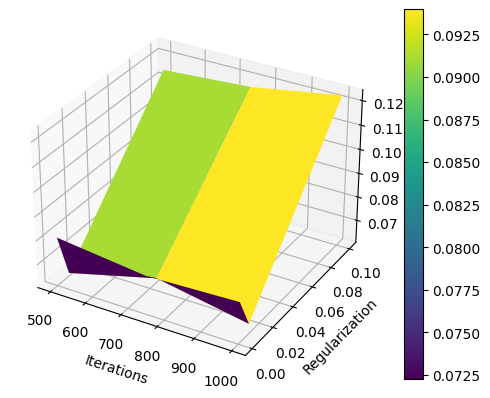

In [21]:
ndcg_values = np.array(ndcg_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(iter_values, lamb_values, ndcg_values.T, cmap=cm.viridis)

ax.set_xlabel('Iterations')
ax.set_ylabel('Regularization')
ax.set_zlabel('nDCG@10')

fig.colorbar(surf)
plt.show()

## Métricas de desempeño

In [32]:
fm_tuned = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=10, l2_reg_w=0.1, l2_reg_V=0.5)
fm_tuned.fit(X_train, y_train)

FMRegression(l2_reg_V=0.5, n_iter=1000, rank=10)

In [33]:
map_value, ndcg, recall, novelty, diversity = evaluate_model(fm_tuned, 10)
print(f"MAP@10: {map_value}")
print(f"nDCG@10: {ndcg}")
print(f"Recall@10: {recall}")
print(f"Novelty: {novelty}")
print(f"Diversity: {diversity}")

MAP@10: 0.10227749289951674
nDCG@10: 0.12314240541677889
Recall@10: 0.1223415175231267
Novelty: 5.804415992190955
Diversity: 0.7248093841642286


### Tiempo de ejecución

In [37]:
start_time = time.time()
fm_train = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=10, l2_reg_w=0.1, l2_reg_V=0.5)
fm_train.fit(X_train, y_train)
end_time = time.time()
print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")

Tiempo de entrenamiento: 18.92544937133789 segundos


### Memoria Utilizada

In [38]:
mem_info_before = psutil.virtual_memory().used
fm_train = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=10, l2_reg_w=0.1, l2_reg_V=0.5)
fm_train.fit(X_train, y_train)
mem_info_after = psutil.virtual_memory().used
print(f"Memoria utilizada: {mem_info_after - mem_info_before} MB")

Memoria utilizada: 4579328 MB


### CPU Utilizada

In [39]:
cpu_usage_before = psutil.cpu_percent(interval=None)
fm_train = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=10, l2_reg_w=0.1, l2_reg_V=0.5)
fm_train.fit(X_train, y_train)
cpu_usage_after = psutil.cpu_percent(interval=None)
print(f"CPU utilizada: {cpu_usage_after - cpu_usage_before}%")

CPU utilizada: 14.899999999999999%


## Ranking con datos de testeo

In [ ]:
import json

test = json.load(open(os.path.join("ranking_template_fill.json")))

In [ ]:
for user in test.keys():
    user_id = int(user)
    ranking = get_top_n_recommendations(fm, user_id)
    ranking = [int(item) for item in ranking]
    test[user] = ranking

In [ ]:
with open(os.path.join("fm_ranking.json"), "w") as file:
    json.dump(test, file, indent=4)